# Parity oscillation analysis
Valid for experiments from 2025-05-22 until ...


In [126]:
date_filters = ["2025-08-22"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

found 4 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-08-22\00\000029813-GeneralVariableScan.h5) scanned over target_780_HWP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-08-22\00\000029813-GeneralVariableScan_atom_photon_parity_3_scan_over_target_780_HWP.h5) scanned over target_780_HWP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-08-22\23\000029814-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-08-22\23\000029814-GeneralVariableScan_microwave_Rabi_2_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse


experiment: atom_photon_parity_3_experiment
override: {'AY_volts_microwave':3.23*V,'p_excitation':0.0,'f_MW_RF_dds':2.761*MHz,'t_MW_RF_pulse':170*us,'target_780_QWP':20.0}
# of iterations:  37


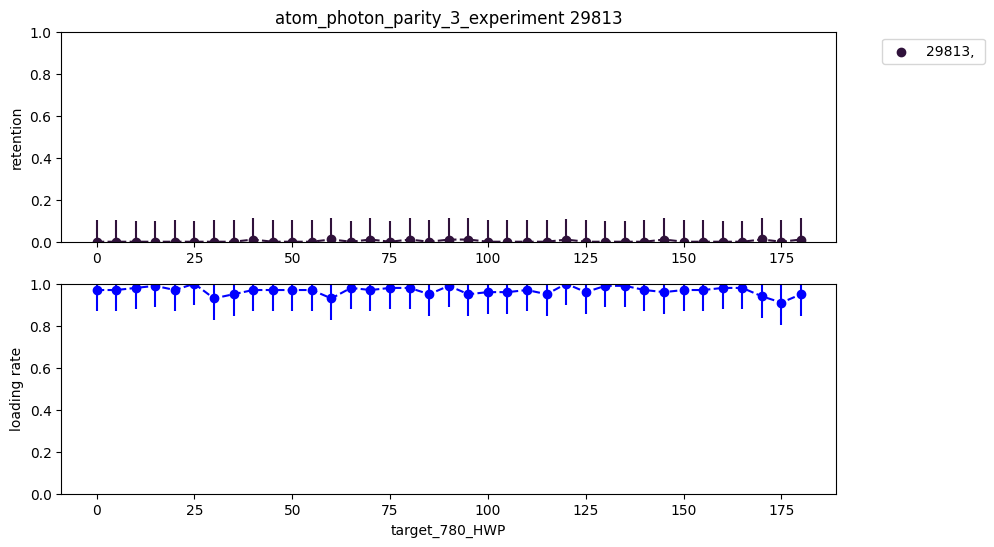

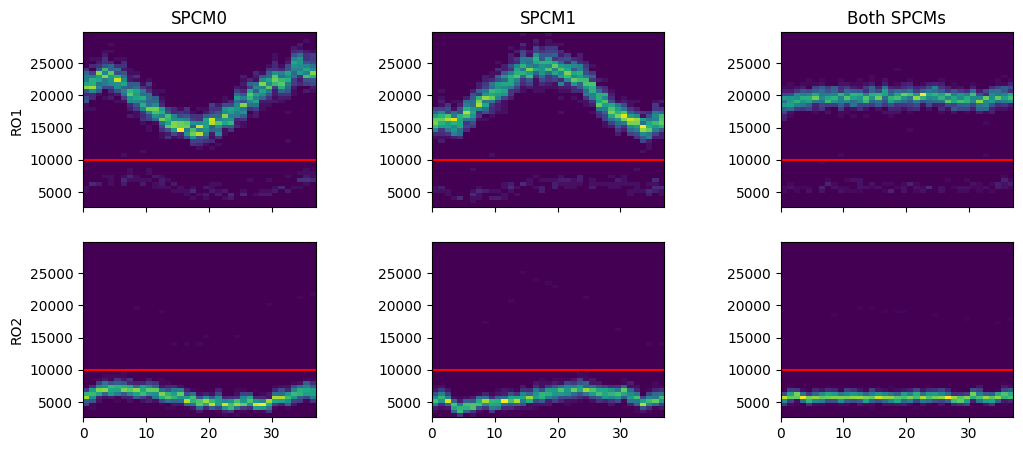

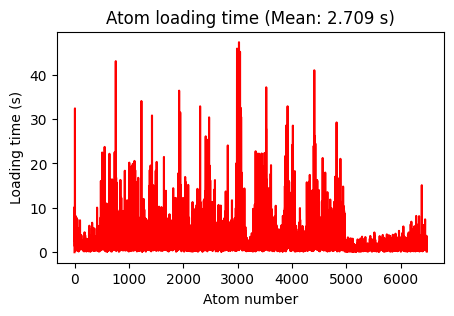

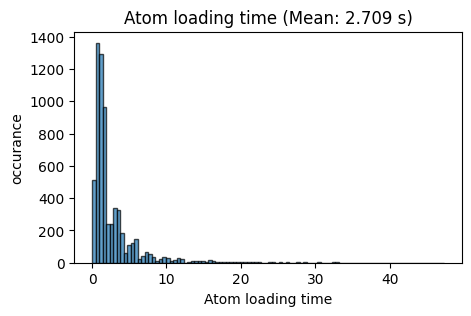

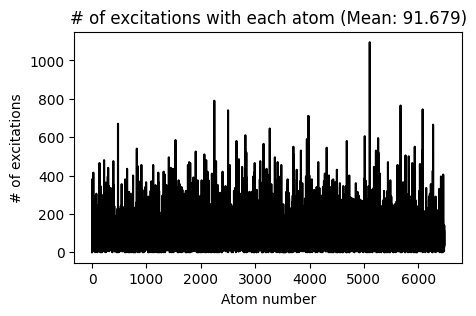

In [127]:
### the file(s) to analyze:
file_indices = {
    0:'',
    # 40:'',
    # 42:'',
} 

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False, figsize=(10, 6))
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


SPCM0_RO1_hists = []
SPCM0_RO2_hists = []
SPCM1_RO1_hists = []
SPCM1_RO2_hists = []
BothSPCMs_RO1_hists = []
BothSPCMs_RO2_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(BothSPCMs_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot
    if showhist:
        SPCM0_RO1_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM0_RO2_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO2_hists.append(
            [np.histogram(SPCM1_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])
        
        BothSPCMs_RO1_hists.append(
            [np.histogram(BothSPCMs_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        BothSPCMs_RO2_hists.append(
            [np.histogram(BothSPCMs_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=False)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            ### for fitting
            ### Auto-detect rough center from minimum retention
            fit_dict = {}
            min_idx = np.argmin(retention_array)
            initial_center = scan_sequence1[min_idx]
            p0 = [initial_center, 10e3, 0.9] # [center, width, depth]
            
            ### using a  Gaussian function for now:
            fit_dict = {
                scan_variable1_name: {
                    'model': lambda x, center, sigma, depth: 0.80*(1 - depth * np.exp(-((x - center)**2/(2*sigma**2)))),
                    'p0': p0,
                    'bounds': ([min(scan_sequence1), 0, 0], [max(scan_sequence1), np.inf, 1]),
                    'params': ['center', 'sigma', 'depth']
                }
            }

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True)  # 2 rows, 3 columns
    ax, ax2, ax3, ax4, ax5, ax6 = axes.ravel()  # Flatten the 2D axes array for easier unpacking

    ### Plot for SPCM0 RO1 in the 1st row, 1st column
    cax = ax.imshow(np.array(SPCM0_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax.set_ylabel("RO1")
    ax.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax.set_aspect('auto')
    ax.set_title("SPCM0")

    ### Plot for SPCM1 RO1 in the 1st row, 2nd column
    cax2 = ax2.imshow(np.array(SPCM1_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax2.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax2.set_aspect('auto')
    ax2.set_title("SPCM1")

    ### Plot for BothSPCMs RO1 in the 1st row, 3rd column
    cax3 = ax3.imshow(np.array(BothSPCMs_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax3.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax3.set_aspect('auto')
    ax3.set_title("Both SPCMs")

    ### Plot for SPCM0 RO2 in the 2nd row, 1st column
    cax4 = ax4.imshow(np.array(SPCM0_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax4.set_ylabel("RO2")
    ax4.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax4.set_aspect('auto')

    ### Plot for SPCM1 RO2 in the 2nd row, 2nd column
    cax5 = ax5.imshow(np.array(SPCM1_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax5.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax5.set_aspect('auto')

    ### Plot for BothSPCMs RO2 in the 2nd row, 3rd column
    cax6 = ax6.imshow(np.array(BothSPCMs_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax6.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax6.set_aspect('auto')

    plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.show()

#######  Atom loading time plot
## We can slice the array to separate iterations later, if we want.
mean_loading_time = np.mean(Atom_loading_time)  
plt.figure(figsize=(5, 3))
plt.plot(Atom_loading_time, 'r-')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(Atom_loading_time, bins=100, edgecolor='black', alpha=0.7)
# plt.plot(Atom_loading_time, 'r-')
plt.xlabel("Atom loading time")
plt.ylabel("occurance")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)")  
plt.show()


mean_number_of_excitations = np.mean(n_excitation_cycles) 
plt.figure(figsize=(5, 3))
plt.plot(n_excitation_cycles, 'k-')
plt.xlabel("Atom number")
plt.ylabel("# of excitations")
plt.title(f"# of excitations with each atom (Mean: {mean_number_of_excitations:.3f})")  
# plt.title("# of excitations for each atom")  
plt.show()


Visibility (SPCM0 | mF=+1): 0.033 ± 0.043  | f=4.500 rad/deg
Visibility (SPCM1 | mF=+1): 0.041 ± 0.041  | f=3.932 rad/deg


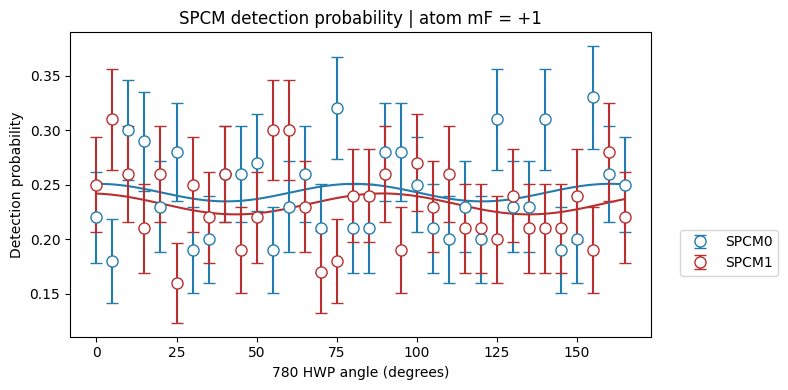

[warn] Some mF=−1 bins have N0+N1 != n_measurements; still normalizing by n_measurements as requested.
Visibility (SPCM0 | mF=−1): 0.244 ± 0.039  | f=4.255 rad/deg
Visibility (SPCM1 | mF=−1): 0.221 ± 0.041  | f=4.173 rad/deg


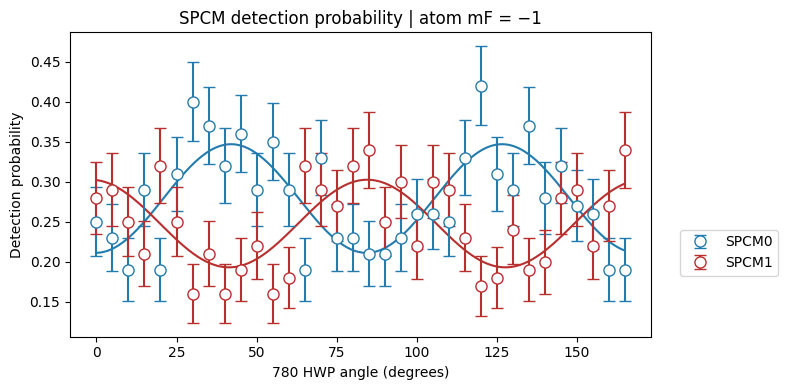

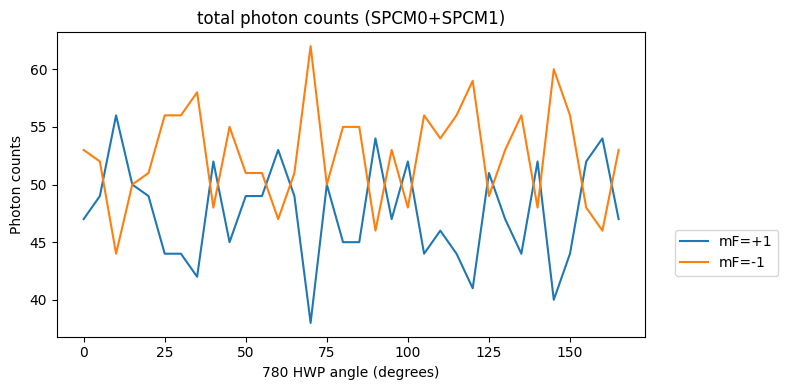

In [128]:
"""
The experiment (e.g. atom_photon_parity_2_experiment) scans the 780_HWP, for example, for a specific 780_QWP. Conditioned on detecting a photon (either from SPCM0 or 1), 
it saves the following datasets: 
BothSPCMs_parity_RO = array([  0, 106, 275, ..., 295, 283, 102]): Showing if atom is in F=1 or in F=2 level.
SPCM0_SinglePhoton = array([0, 0, 1, ..., 1, 0, 0])
SPCM1_SinglePhoton = array([0, 1, 0, ..., 0, 1, 1])
angle_780_HWP = array([  0,   0,   0, ..., 180, 180, 180])
angle_780_QWP = array([20., 20., 20., ..., 20., 20., 20.])

The following arrays will be used in the analysis:
atom_Z1_mask: [True, True, False, ...] is True when the atom is in state mF=+1 (i.e. atom_signal<=single_atom_threshold) in Z-basis.
atom_Zm1_mask: [False, False, True, ...] is True when the atom is in state mF=-1 (i.e. atom_signal>single_atom_threshold) in Z-basis.


"""

color1 = (34/255, 124/255, 174/255)  # blue
color2 = (185/255, 46/255, 46/255)   # red

# -----------------------------------------------------
# Align streams (matches your working convention)
# -----------------------------------------------------
angles = angle_780_HWP                     # no [1:]
spcm0  = (SPCM0_SinglePhoton[1:] > 0)
spcm1  = (SPCM1_SinglePhoton[1:] > 0)
atom_signal   = BothSPCMs_parity_RO[1:] / t_SPCM_second_shot
atom_Z1_mask  = (atom_signal <= single_atom_threshold)   # mF = +1
atom_Zm1_mask = ~atom_Z1_mask                            # mF = −1

unique_angles = np.unique(angles)

# -----------------------------------------------------
# Helpers
# -----------------------------------------------------
def bin_counts_for_state(angles, spcm0, spcm1, atom_mask):
    """Per angle: counts on SPCM0 and SPCM1 within the selected atom state."""
    x, c0, c1 = [], [], []
    for ang in unique_angles:
        sel = (angles == ang) & atom_mask
        n0 = int(np.sum(spcm0 & sel))
        n1 = int(np.sum(spcm1 & sel))
        x.append(ang); c0.append(n0); c1.append(n1)
    return np.array(x), np.array(c0, int), np.array(c1, int)

def binom_err(p, N):
    """Binomial standard error (normal approximation)."""
    N = np.clip(np.asarray(N, int), 1, None)
    p = np.asarray(p, float)
    return np.sqrt(p*(1.0 - p)/N)

def sinusoid_varf(theta_deg, A, f, phi, offset):
    """A * cos(f*theta + phi) + offset  (theta in degrees; f in rad/deg)"""
    return A * np.cos(np.deg2rad(f * theta_deg) + phi) + offset

def fit_sinusoid_prob(x, p, dp, f0=4.0):
    """
    Weighted LSQ fit of A*cos(f*theta + phi) + offset
    with binomial errors as sigma.
    """
    x = np.asarray(x, float)
    p = np.asarray(p, float)
    sigma = np.clip(np.asarray(dp, float), 1e-6, None)

    # Initial guesses
    A0   = (np.nanmax(p) - np.nanmin(p)) / 2.0 if np.isfinite(p).all() else 0.2
    off0 = np.nanmean(p) if np.isfinite(p).all() else 0.5
    phi0 = 0.0

    # Gentle bounds to keep things physical (simple sinusoid, no logistic):
    #   0 ≤ offset ≤ 1,  -1 ≤ A ≤ 1,  -2π ≤ phi ≤ 2π,  3.5 ≤ f ≤ 4.5 (expect ~4)
    bounds = ([-1.0,   3.5, -2*np.pi, 0.0],   # A, f, phi, offset lower
              [ 1.0,  4.5,  2*np.pi, 1.0])  # A, f, phi, offset upper

    p0 = [np.clip(A0, -0.9, 0.9), f0, phi0, np.clip(off0, 0.0, 1.0)]

    popt, pcov = curve_fit(
        sinusoid_varf, x, p, p0=p0,
        bounds=bounds, maxfev=20000
    )
    perr = np.sqrt(np.diag(pcov))

    # Visibility and its uncertainty (delta method on A, offset only)
    A, f, phi, off = popt
    sA, sOff = perr[0], perr[3]
    cov_A_off = pcov[0,3]
    V = np.abs(A) / off
    signA = 1.0 if A >= 0 else -1.0
    if off <= 0:
        V_err = np.nan
    else:
        dV_dA = signA / off
        dV_dOff = -np.abs(A) / (off**2)
        V_var = (dV_dA**2) * (sA**2) + (dV_dOff**2) * (sOff**2) + 2*dV_dA*dV_dOff*cov_A_off
        V_err = np.sqrt(max(V_var, 0.0))

    # Smooth curve
    x_fit = np.linspace(x.min(), x.max(), 400)
    y_fit = sinusoid_varf(x_fit, *popt)
    return popt, perr, (x_fit, y_fit), (V, V_err)

def plot_block(x, p0, dp0, p1, dp1, fit0, fit1, title, save=None):
    fig, ax = plt.subplots(figsize=(8, 4))  # <- capture fig & ax

    # SPCM0
    ax.errorbar(x, p0, yerr=dp0, label='SPCM0', fmt='o',
                mfc='white', mec=color1, ecolor=color1,
                capsize=4, markersize=8, linewidth=1.5, zorder=3)
    ax.plot(fit0[0], fit0[1], color=color1, linestyle='-')

    # SPCM1
    ax.errorbar(x, p1, yerr=dp1, label='SPCM1', fmt='o',
                mfc='white', mec=color2, ecolor=color2,
                capsize=4, markersize=8, linewidth=1.5, zorder=3)
    ax.plot(fit1[0], fit1[1], color=color2, linestyle='-')

    ax.set_xlabel('780 HWP angle (degrees)')
    ax.set_ylabel('Detection probability')
    ax.set_title(title)
    ax.legend(loc=(1.05, 0.2))
    fig.tight_layout()

    if save:
        fig.savefig(save, bbox_inches="tight")  # <- saves THIS figure
    plt.show()
    plt.close(fig)  # optional but avoids grabbing the wrong "current" fig later

# -----------------------------------------------------
# mF = +1  (condition on atom_Z1_mask)
# -----------------------------------------------------
x_Z1, c0_Z1, c1_Z1 = bin_counts_for_state(angles, spcm0, spcm1, atom_Z1_mask)

# Per your statement: denominator per angle is constant n_measurements
N_Z1 = np.full_like(c0_Z1, int(n_measurements), dtype=int)

p0_Z1 = c0_Z1 / N_Z1
p1_Z1 = c1_Z1 / N_Z1
dp0_Z1 = binom_err(p0_Z1, N_Z1)
dp1_Z1 = binom_err(p1_Z1, N_Z1)

popt0_Z1, perr0_Z1, (xfit0_Z1, yfit0_Z1), (V0_Z1, dV0_Z1) = fit_sinusoid_prob(x_Z1, p0_Z1, dp0_Z1, f0=4.0)
popt1_Z1, perr1_Z1, (xfit1_Z1, yfit1_Z1), (V1_Z1, dV1_Z1) = fit_sinusoid_prob(x_Z1, p1_Z1, dp1_Z1, f0=4.0)

print(f"Visibility (SPCM0 | mF=+1): {V0_Z1:.3f} ± {dV0_Z1:.3f}  | f={popt0_Z1[1]:.3f} rad/deg")
print(f"Visibility (SPCM1 | mF=+1): {V1_Z1:.3f} ± {dV1_Z1:.3f}  | f={popt1_Z1[1]:.3f} rad/deg")

plot_block(x_Z1, p0_Z1, dp0_Z1, p1_Z1, dp1_Z1,
           (xfit0_Z1, yfit0_Z1), (xfit1_Z1, yfit1_Z1),
           title='SPCM detection probability | atom mF = +1', save="SPCM_prob_mFplus1.pdf")

# -----------------------------------------------------
# mF = −1  (condition on atom_Zm1_mask)
# -----------------------------------------------------
x_Zm1, c0_Zm1, c1_Zm1 = bin_counts_for_state(angles, spcm0, spcm1, atom_Zm1_mask)

N_Zm1 = np.full_like(c0_Zm1, int(n_measurements), dtype=int)
if np.any((c0_Z1 + c1_Z1 + c0_Zm1 + c1_Zm1) != N_Zm1):
    print("[warn] Some mF=−1 bins have N0+N1 != n_measurements; still normalizing by n_measurements as requested.")

p0_Zm1 = c0_Zm1 / N_Zm1
p1_Zm1 = c1_Zm1 / N_Zm1
dp0_Zm1 = binom_err(p0_Zm1, N_Zm1)
dp1_Zm1 = binom_err(p1_Zm1, N_Zm1)

popt0_Zm1, perr0_Zm1, (xfit0_Zm1, yfit0_Zm1), (V0_Zm1, dV0_Zm1) = fit_sinusoid_prob(x_Zm1, p0_Zm1, dp0_Zm1, f0=4.0)
popt1_Zm1, perr1_Zm1, (xfit1_Zm1, yfit1_Zm1), (V1_Zm1, dV1_Zm1) = fit_sinusoid_prob(x_Zm1, p1_Zm1, dp1_Zm1, f0=4.0)

print(f"Visibility (SPCM0 | mF=−1): {V0_Zm1:.3f} ± {dV0_Zm1:.3f}  | f={popt0_Zm1[1]:.3f} rad/deg")
print(f"Visibility (SPCM1 | mF=−1): {V1_Zm1:.3f} ± {dV1_Zm1:.3f}  | f={popt1_Zm1[1]:.3f} rad/deg")

plot_block(x_Zm1, p0_Zm1, dp0_Zm1, p1_Zm1, dp1_Zm1,
           (xfit0_Zm1, yfit0_Zm1), (xfit1_Zm1, yfit1_Zm1),
           title='SPCM detection probability | atom mF = −1', save="SPCM_prob_mFminus1.pdf")


######################################################
### plotting the sum of all data for checking 
plt.figure(figsize=(8, 4))
plt.plot(x_Z1, c0_Z1+c1_Z1, label="mF=+1")
plt.plot(x_Zm1, c0_Zm1+c1_Zm1, label="mF=-1")

plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('total photon counts (SPCM0+SPCM1)')
plt.legend(loc=(1.05,0.2))
plt.tight_layout()
plt.show()

[SPCM0] Visibility (mF=+1 | SPCM0): 0.140 ± 0.035  | f=4.437 rad/deg


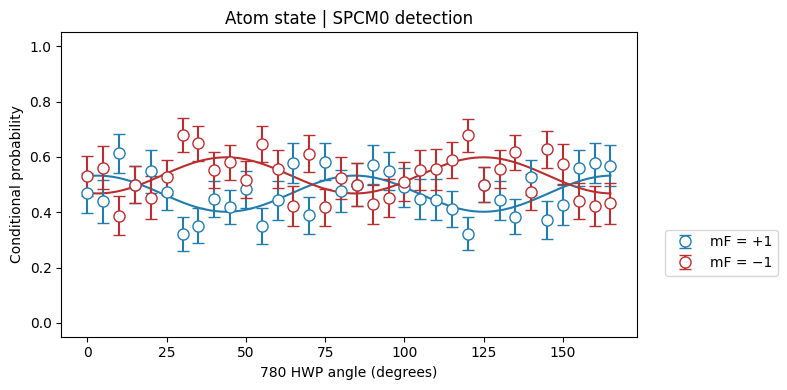

[SPCM1] Visibility (mF=+1 | SPCM1): 0.098 ± 0.031  | f=4.500 rad/deg


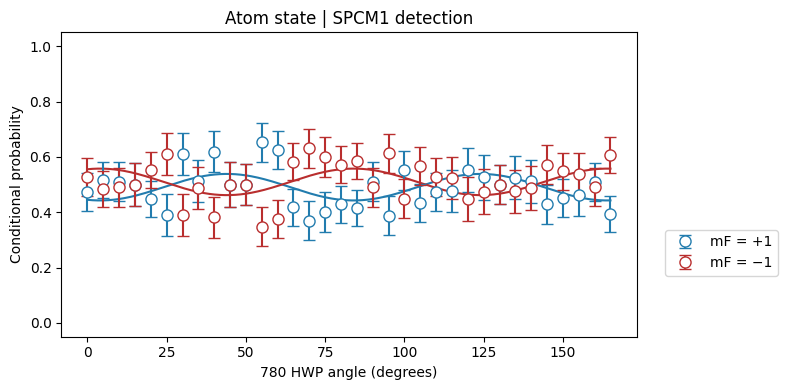

In [129]:

# --------------------------------------------
# Helpers for "atom state | SPCM detection"
# --------------------------------------------
def binom_prob_given_spcm(angles, spcm_mask, success_mask):
    """
    Per HWP angle, among trials where the chosen SPCM fired (spcm_mask=True),
    compute p = (#success atom state) / (#SPCM detections).
    Returns x, p, dp (binomial), and N per angle.
    """
    x, p, dp, N_list = [], [], [], []
    for ang in unique_angles:
        sel = (angles == ang) & spcm_mask
        N = int(np.sum(sel))              # denominator: # of detections on this SPCM at this angle
        if N == 0:
            x.append(ang); p.append(np.nan); dp.append(np.nan); N_list.append(0)
            continue
        S = int(np.sum(success_mask & sel))  # successes: atom in mF=+1 (or mF=-1) within those detections
        phat = S / N
        err = np.sqrt(phat*(1.0 - phat)/N)  # binomial SE
        x.append(ang); p.append(phat); dp.append(err); N_list.append(N)
    return np.array(x), np.array(p, float), np.array(dp, float), np.array(N_list, int)

def fit_masked(x, p, dp, f0=4.0):
    """
    Apply your sinusoid fit to finite points only.
    Returns (popt, perr, (xfit,yfit), (V, dV)) or None if insufficient data.
    """
    m = np.isfinite(x) & np.isfinite(p) & np.isfinite(dp) & (dp > 0)
    if np.count_nonzero(m) < 4:
        return None
    return fit_sinusoid_prob(x[m], p[m], dp[m], f0=f0)

def plot_atom_state_given_spcm(x, p_plus, dp_plus, p_minus, dp_minus, fit_plus, title, save=None):
    fig, ax = plt.subplots(figsize=(8, 4))

    # +1
    ax.errorbar(x, p_plus, yerr=dp_plus, label='mF = +1', fmt='o',
                mfc='white', mec=color1, ecolor=color1,
                capsize=4, markersize=8, linewidth=1.5, zorder=3)
    if fit_plus is not None:
        xfit, yfit = fit_plus[2]
        ax.plot(xfit, yfit, color=color1, linestyle='-')

    # −1 (complement)
    ax.errorbar(x, p_minus, yerr=dp_minus, label='mF = −1', fmt='o',
                mfc='white', mec=color2, ecolor=color2,
                capsize=4, markersize=8, linewidth=1.5, zorder=3)
    if fit_plus is not None:
        ax.plot(xfit, 1.0 - yfit, color=color2, linestyle='-')

    ax.set_xlabel('780 HWP angle (degrees)')
    ax.set_ylabel('Conditional probability')
    ax.set_title(title)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc=(1.05, 0.2))
    fig.tight_layout()

    if save:
        fig.savefig(save, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# ============================================
# SPCM0:  P(atom | SPCM0 detection)
# ============================================
x0, pZ1_0, dpZ1_0, N0 = binom_prob_given_spcm(angles, spcm_mask=spcm0, success_mask=atom_Z1_mask)
# Complement for mF=-1:
pZm1_0  = 1.0 - pZ1_0
dpZm1_0 = dpZ1_0   # var(p) = var(1-p) for binomial

fitZ1_0 = fit_masked(x0, pZ1_0, dpZ1_0, f0=4.0)
if fitZ1_0 is not None:
    (A0,f0_hat,phi0,off0), perr0, _, (V0, dV0) = fitZ1_0
    print(f"[SPCM0] Visibility (mF=+1 | SPCM0): {V0:.3f} ± {dV0:.3f}  | f={f0_hat:.3f} rad/deg")
else:
    print("[SPCM0] Not enough finite data to fit.")

plot_atom_state_given_spcm(x0, pZ1_0, dpZ1_0, pZm1_0, dpZm1_0, fitZ1_0,
                           title='Atom state | SPCM0 detection', save='Atom_given_SPCM0.pdf')

# ============================================
# SPCM1:  P(atom | SPCM1 detection)
# ============================================
x1, pZ1_1, dpZ1_1, N1 = binom_prob_given_spcm(angles, spcm_mask=spcm1, success_mask=atom_Z1_mask)
# Complement for mF=-1:
pZm1_1  = 1.0 - pZ1_1
dpZm1_1 = dpZ1_1

fitZ1_1 = fit_masked(x1, pZ1_1, dpZ1_1, f0=4.0)
if fitZ1_1 is not None:
    (A1,f1_hat,phi1,off1), perr1, _, (V1, dV1) = fitZ1_1
    print(f"[SPCM1] Visibility (mF=+1 | SPCM1): {V1:.3f} ± {dV1:.3f}  | f={f1_hat:.3f} rad/deg")
else:
    print("[SPCM1] Not enough finite data to fit.")

plot_atom_state_given_spcm(x1, pZ1_1, dpZ1_1, pZm1_1, dpZm1_1, fitZ1_1,
                           title='Atom state | SPCM1 detection', save='Atom_given_SPCM1.pdf')


## old way (to be deleted)

Fringe visibility (SPCM0 | mF=+1) = 0.923 ± 0.048
Fringe visibility (SPCM1 | mF=+1) = 0.922 ± 0.039


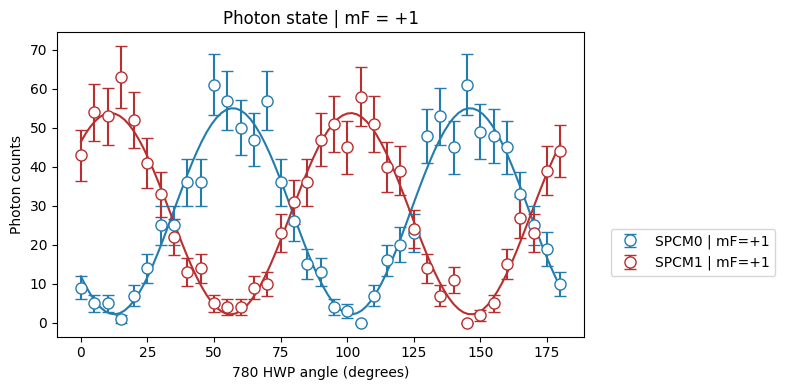

Fringe visibility (SPCM0 | mF=-1) = 0.754 ± 0.049
Fringe visibility (SPCM1 | mF=-1) = 0.661 ± 0.042


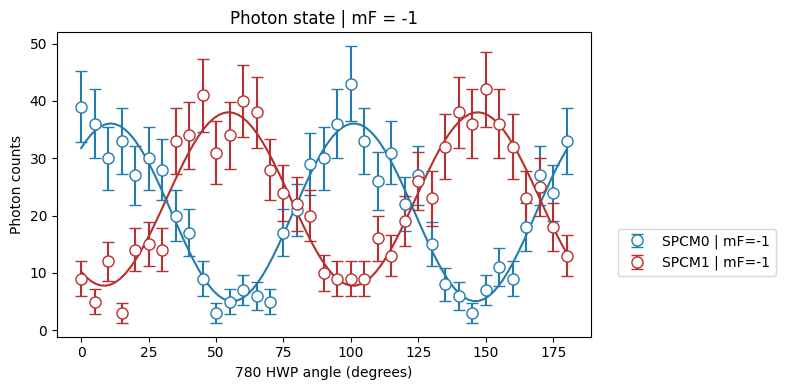

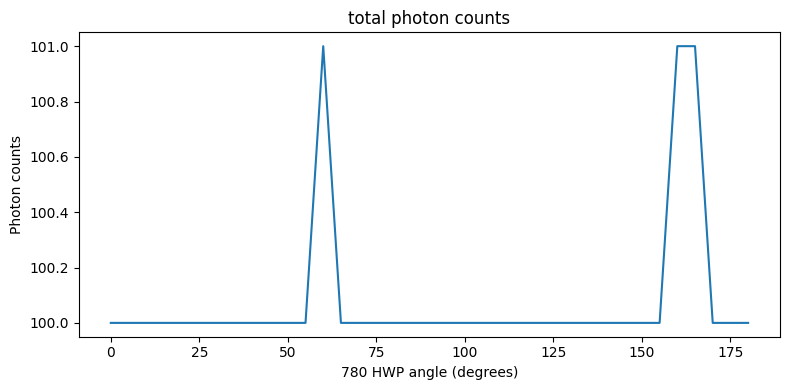

In [779]:
"""
The experiment (e.g. atom_photon_parity_2_experiment) scans the 780_HWP, for example, for a specific 780_QWP. Conditioned on detecting a photon (either from SPCM0 or 1), 
it saves the following datasets: 
BothSPCMs_parity_RO = array([  0, 106, 275, ..., 295, 283, 102]): Showing if atom is in F=1 or in F=2 level.
SPCM0_SinglePhoton = array([0, 0, 1, ..., 1, 0, 0])
SPCM1_SinglePhoton = array([0, 1, 0, ..., 0, 1, 1])
angle_780_HWP = array([  0,   0,   0, ..., 180, 180, 180])
angle_780_QWP = array([20., 20., 20., ..., 20., 20., 20.])

The following arrays will be used in the analysis:
atom_Z1_mask: [True, True, False, ...] is True when the atom is in state mF=+1 (i.e. atom_signal<=single_atom_threshold) in Z-basis.
atom_Zm1_mask: [False, False, True, ...] is True when the atom is in state mF=-1 (i.e. atom_signal>single_atom_threshold) in Z-basis.
unique_angles_780_HWP = [0,10,20,...]
angle_780_HWP_Z1_filtered = [0,0,0,10,10,20,...]

"""

color1 = (34/255, 124/255, 174/255) ### blue
color2 = (185/255, 46/255, 46/255) ### red

### Compute atom state
atom_signal = BothSPCMs_parity_RO[1:] / t_SPCM_second_shot
atom_Z1_mask = atom_signal <= single_atom_threshold
atom_Zm1_mask = ~atom_Z1_mask

### Unify the HWP angles
unique_angles_780_HWP = np.unique(angle_780_HWP)

#########################################################################  Plot for mF = +1
angle_780_HWP_Z1_filtered = angle_780_HWP[atom_Z1_mask]
SPCM0_Z1_filtered = SPCM0_SinglePhoton[1:][atom_Z1_mask]
SPCM1_Z1_filtered = SPCM1_SinglePhoton[1:][atom_Z1_mask]

SPCM0_counts_Z1_filtered = []
SPCM1_counts_Z1_filtered = []
SPCM0_errors_Z1_filtered = []
SPCM1_errors_Z1_filtered = []

for angle in unique_angles_780_HWP:
    angle_mask = angle_780_HWP_Z1_filtered == angle
    count0 = np.sum(SPCM0_Z1_filtered[angle_mask])
    count1 = np.sum(SPCM1_Z1_filtered[angle_mask])
    SPCM0_counts_Z1_filtered.append(count0)
    SPCM1_counts_Z1_filtered.append(count1)
    SPCM0_errors_Z1_filtered.append(np.sqrt(count0))
    SPCM1_errors_Z1_filtered.append(np.sqrt(count1))


############################## curve fitting to sin(x)
def sinusoid(x, A, f, phi, offset):
    return A * np.cos(np.deg2rad(f * x) + phi) + offset

######## Curve fit for SPCM0 | mF = +1
popt, pcov = curve_fit(sinusoid, unique_angles_780_HWP, SPCM0_counts_Z1_filtered,
                         p0=[100, 5, 0, 40])  # initial guess: [amplitude, frequency, phase, offset]
perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties

A = popt[0]
A_err = perr[0]
offset = popt[3]
offset_err = perr[3]
fringe_visibility = np.abs(A)/offset
fringe_visibility_err = np.sqrt((A_err / offset)**2 + (A * offset_err / offset**2)**2)
print(f"Fringe visibility (SPCM0 | mF=+1) = {fringe_visibility:.3f} ± {fringe_visibility_err:.3f}")

### Generate smooth x values for plotting the fit
x_fit = np.linspace(min(unique_angles_780_HWP), max(unique_angles_780_HWP), 100)
y_fit_SPCM0_Z1 = sinusoid(x_fit, *popt)

######## Curve fit for SPCM1 | mF = +1
popt, pcov = curve_fit(sinusoid, unique_angles_780_HWP, SPCM1_counts_Z1_filtered,
                         p0=[100, 5, 0, 1])  # initial guess: [amplitude, frequency, phase, offset]
perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties

A = popt[0]
A_err = perr[0]
offset = popt[3]
offset_err = perr[3]
fringe_visibility = np.abs(A)/offset
fringe_visibility_err = np.sqrt((A_err / offset)**2 + (A * offset_err / offset**2)**2)
print(f"Fringe visibility (SPCM1 | mF=+1) = {fringe_visibility:.3f} ± {fringe_visibility_err:.3f}")

### Generate smooth x values for plotting the fit
y_fit_SPCM1_Z1 = sinusoid(x_fit, *popt)
###################################################

plt.figure(figsize=(8, 4))

plt.errorbar(unique_angles_780_HWP, SPCM0_counts_Z1_filtered, yerr=SPCM0_errors_Z1_filtered, label='SPCM0 | mF=+1',
             fmt='o', mfc='white', mec=color1, ecolor=color1,
             capsize=4, markersize=8, linewidth=1.5, zorder=3)
plt.plot(x_fit, y_fit_SPCM0_Z1, color=color1, linestyle='-')

plt.errorbar(unique_angles_780_HWP, SPCM1_counts_Z1_filtered, yerr=SPCM1_errors_Z1_filtered, label='SPCM1 | mF=+1',
             fmt='o', mfc='white', mec=color2, ecolor=color2,
             capsize=4, markersize=8, linewidth=1.5, zorder=3)
plt.plot(x_fit, y_fit_SPCM1_Z1, color=color2, linestyle='-')


plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('Photon state | mF = +1')
plt.legend(loc=(1.05,0.2))
plt.tight_layout()
plt.savefig('Parity_Oscillation_2025-05-28_RID26026.pdf',bbox_inches='tight')
plt.show()

##################################################################################  Plot for mF = -1
angle_780_HWP_Zm1_filtered = angle_780_HWP[atom_Zm1_mask]
SPCM0_Zm1_filtered = SPCM0_SinglePhoton[1:][atom_Zm1_mask]
SPCM1_Zm1_filtered = SPCM1_SinglePhoton[1:][atom_Zm1_mask]

SPCM0_counts_Zm1_filtered = []
SPCM1_counts_Zm1_filtered = []
SPCM0_errors_Zm1_filtered = []
SPCM1_errors_Zm1_filtered = []

for angle in unique_angles_780_HWP:
    angle_mask = angle_780_HWP_Zm1_filtered == angle
    count0 = np.sum(SPCM0_Zm1_filtered[angle_mask])
    count1 = np.sum(SPCM1_Zm1_filtered[angle_mask])
    SPCM0_counts_Zm1_filtered.append(count0)
    SPCM1_counts_Zm1_filtered.append(count1)
    SPCM0_errors_Zm1_filtered.append(np.sqrt(count0))
    SPCM1_errors_Zm1_filtered.append(np.sqrt(count1))


############################## curve fitting to sin(x)
######## Curve fit for SPCM0 | mF = -1
popt, pcov = curve_fit(sinusoid, unique_angles_780_HWP, SPCM0_counts_Zm1_filtered,
                         p0=[100, 5, 0, 1])  # initial guess: [amplitude, frequency, phase, offset]
perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties

A = popt[0]
A_err = perr[0]
offset = popt[3]
offset_err = perr[3]
fringe_visibility = np.abs(A)/offset
fringe_visibility_err = np.sqrt((A_err / offset)**2 + (A * offset_err / offset**2)**2)
print(f"Fringe visibility (SPCM0 | mF=-1) = {fringe_visibility:.3f} ± {fringe_visibility_err:.3f}")

### Generate smooth x values for plotting the fit
x_fit = np.linspace(min(unique_angles_780_HWP), max(unique_angles_780_HWP), 100)
y_fit_SPCM0_Zm1 = sinusoid(x_fit, *popt)

######## Curve fit for SPCM1 | mF = -1
popt, pcov = curve_fit(sinusoid, unique_angles_780_HWP, SPCM1_counts_Zm1_filtered,
                         p0=[100, 5, 0, 1])  # initial guess: [amplitude, frequency, phase, offset]
perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties

A = popt[0]
A_err = perr[0]
offset = popt[3]
offset_err = perr[3]
fringe_visibility = np.abs(A)/offset
fringe_visibility_err = np.sqrt((A_err / offset)**2 + (A * offset_err / offset**2)**2)
print(f"Fringe visibility (SPCM1 | mF=-1) = {fringe_visibility:.3f} ± {fringe_visibility_err:.3f}")

### Generate smooth x values for plotting the fit
y_fit_SPCM1_Zm1 = sinusoid(x_fit, *popt)
######################################################

plt.figure(figsize=(8, 4))

plt.errorbar(unique_angles_780_HWP, SPCM0_counts_Zm1_filtered, yerr=SPCM0_errors_Zm1_filtered, label='SPCM0 | mF=-1',
             fmt='o', mfc='white', mec=color1, ecolor=color1,
             capsize=4, markersize=8, linewidth=1.5, zorder=3)
plt.plot(x_fit, y_fit_SPCM0_Zm1, color=color1, linestyle='-')

plt.errorbar(unique_angles_780_HWP, SPCM1_counts_Zm1_filtered, yerr=SPCM1_errors_Zm1_filtered, label='SPCM1 | mF=-1',
             fmt='o', mfc='white', mec=color2, ecolor=color2,
             capsize=4, markersize=8, linewidth=1.5, zorder=3)
plt.plot(x_fit, y_fit_SPCM1_Zm1, color=color2, linestyle='-')

plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('Photon state | mF = -1')
plt.legend(loc=(1.05,0.2))
plt.tight_layout()
plt.show()


######################################################
### plotting the sum of all data for checking 
plt.figure(figsize=(8, 4))
plt.plot(unique_angles_780_HWP, 
             np.array(SPCM0_counts_Z1_filtered)+
             np.array(SPCM0_counts_Zm1_filtered)+
             np.array(SPCM1_counts_Z1_filtered)+
             np.array(SPCM1_counts_Zm1_filtered), 
        )

plt.xlabel('780 HWP angle (degrees)')
plt.ylabel('Photon counts')
plt.title('total photon counts')
plt.tight_layout()
plt.show()
